In [6]:
!pip install opencv-python
!pip install tensorflow
!pip install glob

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import cv2 as cv
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import models, layers, activations, \
optimizers, utils, losses, initializers, metrics, callbacks

In [14]:
# Transformada de Fourier
def fft(img):
    img = np.fft.fft2(img)
    img = np.fft.fftshift(img)
    return img
# Inversa (retorna para imagem original)
def ifft(fimg):
    fimg = np.fft.ifftshift(fimg)
    fimg = np.fft.ifft2(fimg)
    return fimg
# Obtém a magnitude da imagem
def mag(img):
    absvalue = np.abs(img)
    magnitude = 20 * np.log(absvalue)
    return magnitude
# Normaliza a imagem entre 0 e 255
def norm(img):
    img = cv.normalize(
        img, None, 0, 255,
        cv.NORM_MINMAX
    )
# Melhor para ver imagens da transformada e imagens pequenas em geral.
def show(img):
    plt.imshow(img, cmap='gray')
    plt.show()
    return img

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [9]:
folders = glob.glob('data\\original\\*')
images_list = []
for folder in folders:
    for f in glob.glob(folder+'/*.jpg'):
        images_list.append(f)

data\original\0


In [17]:
# Get all original images
imgs0 = load_images_from_folder("data/original/0/")
imgs1 = load_images_from_folder("data/original/1/")
imgs2 = load_images_from_folder("data/original/2/")
imgs3 = load_images_from_folder("data/original/3/")
imgs4 = load_images_from_folder("data/original/4/")
imgs5 = load_images_from_folder("data/original/5/")

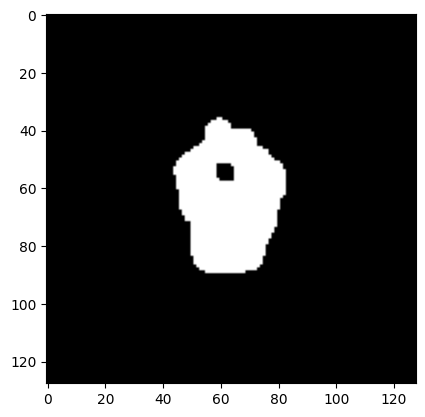

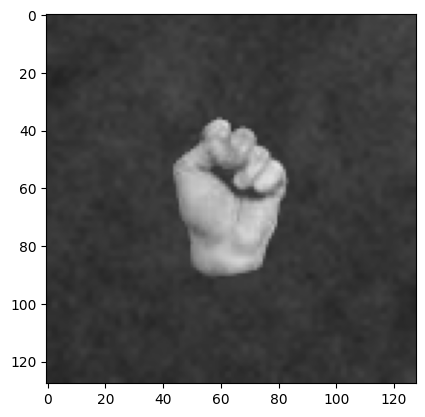

array([[[54, 54, 54],
        [53, 53, 53],
        [51, 51, 51],
        ...,
        [64, 64, 64],
        [66, 66, 66],
        [67, 67, 67]],

       [[54, 54, 54],
        [53, 53, 53],
        [50, 50, 50],
        ...,
        [66, 66, 66],
        [67, 67, 67],
        [68, 68, 68]],

       [[55, 55, 55],
        [53, 53, 53],
        [49, 49, 49],
        ...,
        [71, 71, 71],
        [70, 70, 70],
        [69, 69, 69]],

       ...,

       [[42, 42, 42],
        [42, 42, 42],
        [44, 44, 44],
        ...,
        [65, 65, 65],
        [64, 64, 64],
        [64, 64, 64]],

       [[44, 44, 44],
        [43, 43, 43],
        [42, 42, 42],
        ...,
        [65, 65, 65],
        [67, 67, 67],
        [68, 68, 68]],

       [[45, 45, 45],
        [44, 44, 44],
        [41, 41, 41],
        ...,
        [65, 65, 65],
        [68, 68, 68],
        [70, 70, 70]]], dtype=uint8)

In [64]:
original_images = [
    imgs0, imgs1, imgs2, imgs3, imgs4, imgs5
]
# show(original_images[0][0])
limiarized = [
    [],
    [],
    [],
    [],
    [],
    []
]

for i in range(6):
    for img in original_images[i]:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # print(img)
        threshold, img = cv.threshold(
            img, 0, 255, cv.THRESH_OTSU
        )

        img = cv.dilate(img, np.ones((5, 5)))
        img = cv.erode(img, np.ones((5, 5)))

        limiarized[i].append(img)
        # show(img)
show(limiarized[0][0])
show(original_images[0][0])


In [65]:
for i in range(len(limiarized)):
    # Create a folder for the current index if it doesn't exist
    folder_path = f"data/Binarized/{i}"
    os.makedirs(folder_path, exist_ok=True)

    # Loop through each binary image in limiarized[i]
    for img_index, img in enumerate(limiarized[i]):
        # Get the original image name
        original_img_name = f"data/original/{i}/{img_index}.png"  # Update this according to your file naming convention

        # Save the binary image with the original name in the corresponding folder
        save_path = os.path.join(folder_path, os.path.basename(original_img_name))
        cv.imwrite(save_path, img)

In [68]:
folder_path = 'Binarized'
epochs = 100
batch_size = 32
patience = 5
learning_rate = 0.0001
model_path = f'checkpoints/{folder_path}/modelB.keras'
exists = os.path.exists(model_path)

# Carrega modelo se já existir um checkpoint, caso contrário, o cria.
if exists:
    model = models.load_model(model_path)
else: 
    model = models.Sequential([
        layers.Resizing(64, 64),
        layers.Rescaling(1.0/255),
        layers.BatchNormalization(axis=1),
        layers.Conv2D(16, (5, 5),
            activation = 'relu',
            kernel_initializer = initializers.RandomNormal()
            ),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3),
            activation = 'relu',
            kernel_initializer = initializers.RandomNormal()
        ),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3),
            activation = 'relu',
            kernel_initializer = initializers.RandomNormal()
        ),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128,
            activation = 'relu',
            kernel_initializer = initializers.RandomNormal()
        ),
        layers.Dense(64,
            activation = 'relu',
            kernel_initializer = initializers.RandomNormal()
        ),
        layers.Dense(32,
            activation = 'relu',
            kernel_initializer = initializers.RandomNormal()
        ),
        layers.Dense(16,
            activation = 'relu',
            kernel_initializer = initializers.RandomNormal()
        ),
        layers.Dense(8,
            activation = 'relu',
            kernel_initializer = initializers.RandomNormal()
        ),
        layers.Dense(6,
            activation = 'sigmoid',
            kernel_initializer = initializers.RandomNormal()
        )
        ])

if exists:
    model.summary()
else:
    model.compile(
    optimizer = optimizers.Adam(
    learning_rate = learning_rate
),
    loss = losses.SparseCategoricalCrossentropy(),
    metrics = [ 'accuracy' ]
)
    
train = utils.image_dataset_from_directory(
    f"data/{folder_path}",
    validation_split= 0.2,
    subset= "training",
    seed= 123,
    shuffle= True,
    image_size= (128, 128),
    batch_size= batch_size
    )

test = utils.image_dataset_from_directory(
    f"data/{folder_path}",
    validation_split= 0.2,
    subset= "validation",
    seed= 123,
    shuffle= True,
    image_size= (128, 128),
    batch_size= batch_size
    )

model.fit(train,
    epochs = epochs,
    validation_data = test,
    callbacks= [
        callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = patience,
            verbose = 1
        ),
        callbacks.ModelCheckpoint(
            filepath = model_path,
            save_weights_only = False,
            monitor = 'loss',
            mode = 'min',
            save_best_only = True
        )
    ]
)

Found 18000 files belonging to 6 classes.
Using 14400 files for training.
Found 18000 files belonging to 6 classes.
Using 3600 files for validation.
Epoch 1/100
450/450 [==============================] - 10s 21ms/step - loss: 1.1598 - accuracy: 0.5098 - val_loss: 0.3158 - val_accuracy: 0.8986
Epoch 2/100
450/450 [==============================] - 9s 21ms/step - loss: 0.1934 - accuracy: 0.9376 - val_loss: 0.0514 - val_accuracy: 0.9844
Epoch 3/100
450/450 [==============================] - 9s 21ms/step - loss: 0.0809 - accuracy: 0.9701 - val_loss: 0.0254 - val_accuracy: 0.9950
Epoch 4/100
450/450 [==============================] - 10s 22ms/step - loss: 0.0538 - accuracy: 0.9818 - val_loss: 0.0157 - val_accuracy: 0.9953
Epoch 5/100
450/450 [==============================] - 10s 23ms/step - loss: 0.0481 - accuracy: 0.9836 - val_loss: 0.0104 - val_accuracy: 0.9975
Epoch 6/100
450/450 [==============================] - 11s 24ms/step - loss: 0.0332 - accuracy: 0.9885 - val_loss: 0.0065 - val_

KeyboardInterrupt: 